## Planteamiento del problema

La primera pregunta que queremos responder es
**¿El ruido uniforme en las etiquetas, reduciendo (en número y proporción) el número de datos limpios, afecta al rendimiento?**

En este experimento, consideraremos el siguiente escenario:
- Tenemos $n$ imágenes con etiquetas limpias.
- Tomamos $m < n$ imágenes y cambiamos su etiqueta por una aleatoria entre las posibles.
- Por tanto, tenemos $m$ imágenes con etiquetas ruidosas y $n-m$ imágenes no ruidosas.

Las arquitecturas y *dataset* que utilizaremos en este experimento serán:
- Trabajaremos con el conjunto de datos CIFAR-10.
- Trabarejemos con varios modelos con distinto orden de complejidad: MLP con 2 capas ocultas, redes neuronales con 4 y 6 capas convolucionales, respectivamente y ResNet18.
- Utilizaremos ruido uniforme, en el que la etiqueta ruidosa se asigna aleatoriamente entre las clases posibles, todas con la misma probabilidad.

Realizaremos el entrenamiento con el conjunto de datos ruidoso y evaluaremos su rendimiento en un conjunto de test limpio (sin ruido).

## Instalación de fastai

In [ ]:
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from fastai.vision.all import *
import fastai
import numpy

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("FastAI:", fastai.__version__)
print("NumPy:", numpy.__version__)

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch: 2.6.0+cu124
CUDA disponible: True
FastAI: 2.8.2
NumPy: 2.0.2


## Carga del *dataset* CIFAR-10

Descargamos el *dataset* CIFAR-10:

In [ ]:
# We get the CIFAR10 dataset
path = untar_data(URLs.CIFAR,force_download=True)

In [ ]:
# The CIFAR_10 dataset follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()

/root/.fastai/data/cifar10
[Path('/root/.fastai/data/cifar10/train'), Path('/root/.fastai/data/cifar10/test'), Path('/root/.fastai/data/cifar10/labels.txt')]
[Path('/root/.fastai/data/cifar10/train/airplane'), Path('/root/.fastai/data/cifar10/train/cat'), Path('/root/.fastai/data/cifar10/train/bird'), Path('/root/.fastai/data/cifar10/train/deer'), Path('/root/.fastai/data/cifar10/train/automobile'), Path('/root/.fastai/data/cifar10/train/truck'), Path('/root/.fastai/data/cifar10/train/dog'), Path('/root/.fastai/data/cifar10/train/frog'), Path('/root/.fastai/data/cifar10/train/horse'), Path('/root/.fastai/data/cifar10/train/ship')]
[Path('/root/.fastai/data/cifar10/test/airplane'), Path('/root/.fastai/data/cifar10/test/cat'), Path('/root/.fastai/data/cifar10/test/bird'), Path('/root/.fastai/data/cifar10/test/deer'), Path('/root/.fastai/data/cifar10/test/automobile'), Path('/root/.fastai/data/cifar10/test/truck'), Path('/root/.fastai/data/cifar10/test/dog'), Path('/root/.fastai/data/cifa

Comprobamos que efectivamente disponemos de $50000$ ejemplos de entrenamiento y $10000$ de *test*, que el tamaño de las imágenes es $32\times 32\times 3$ y que el número de clases es $10$.

In [ ]:
from cv2 import imread

n_training = np.sum([len(class_files.ls()) for class_files in train_classes])
n_test = np.sum([len(class_files.ls()) for class_files in test_classes])

img = imread(path/'train'/'deer'/'10006_deer.png')
width, height, num_channels = img.shape
num_classes = len(train_classes)

print(f"Número de imágenes de entrenamiento: {n_training}")
print(f"Número de imágenes de test: {n_test}")
print(f"Tamaño de las imágenes: {width}x{height}x{num_channels}")
print(f"Número de clases: {num_classes}")

Número de imágenes de entrenamiento: 50000
Número de imágenes de test: 10000
Tamaño de las imágenes: 32x32x3
Número de clases: 10


Seleccionamos un valor para $\alpha$, la proporción de ruido deseado y fijamos la semilla aleatoria con el fin de garantizar la reproducibilidad en la mayor medida posible.

In [ ]:
prop_ruido = 0
alpha = 0
random.seed(42)

Seleccionamos todas las imágenes del entrenamiento y las repetimos tantas veces como indique $\alpha$:

In [ ]:
def repeat_images(images, alpha):
    """Devuelve una lista con cada imagen repetida alpha veces."""
    return L(img for img in images for _ in range(alpha+1))

In [ ]:
selected_images = get_image_files(path/'train')
selected_images = repeat_images(selected_images, alpha)

In [ ]:
len(selected_images)

50000

Creamos una función que selecciona las imágenes del conjunto de entrenamiento, y les asigna una etiqueta de forma aleatoria (uniforme):

In [ ]:
possible_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_labels(images):
  i = 0
  labels = []

  for i in range(len(images)):
    labels.append(parent_label(images[i]))

  cantidad = int(prop_ruido*len(images))
  inds_cambio = random.sample(range(len(images)), cantidad)

  for i in inds_cambio:
    labels[i] = random.choice(possible_labels)

  return labels

In [ ]:
labels = get_labels(selected_images)

Mostramos el número de etiquetas incorrectas en el *dataset*:

In [ ]:
num_incorrectas = 0
for i in range(len(labels)):
  if labels[i] != parent_label(selected_images[i]):
    num_incorrectas += 1

print(f"Número real de etiquetas incorrectas:     {num_incorrectas}")

prob_etiqueta_incorrecta = (num_classes-1)/num_classes
print(f"Número esperado de etiquetas incorrectas: {int(prop_ruido*n_training*prob_etiqueta_incorrecta)}")

Número real de etiquetas incorrectas:     0
Número esperado de etiquetas incorrectas: 0


Combinamos todo en un *datablock* (que es la forma que tiene fastai de gestionar los datos de entrada):

In [ ]:
batch_size = 128
valid_part = 0.2

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda _: range(0,len(selected_images)),
    get_x=lambda x: selected_images[x],
    get_y=lambda x: labels[x],
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=[
        Normalize()
    ]
)

dls = dblock.dataloaders(path/'train', bs=128)

Mostramos algunos ejemplos de nuestros datos de entrada:

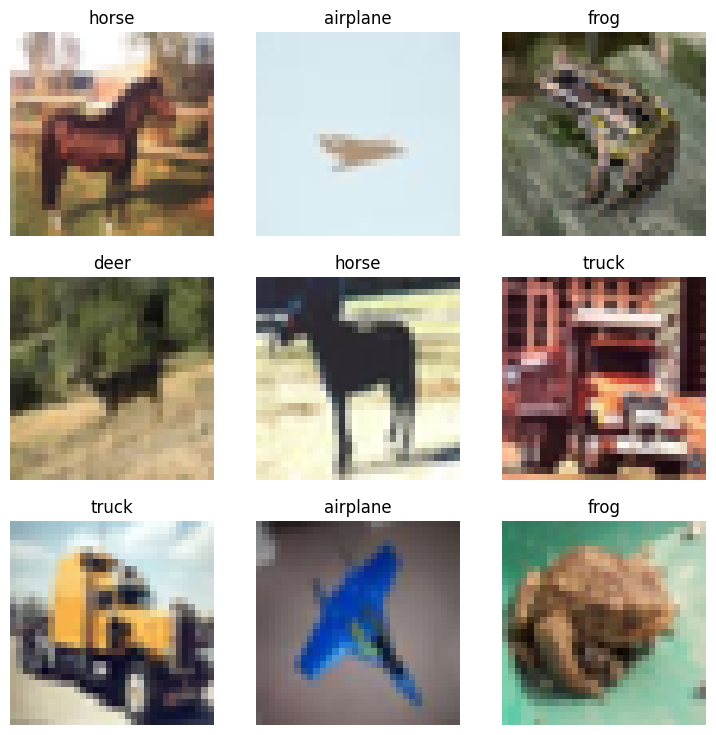

In [ ]:
dls.show_batch(max_n=9)

## Arquitecturas de redes neuronales

Creamos y entrenamos los distintos modelos durante un cierto número de épocas.

In [ ]:
num_epochs = 10
early_stopping_patience = 3

### MLP-2

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

En primer lugar, consideramos un MLP con $2$ capas ocultas.

#### Creación del modelo

In [ ]:
from torch.nn import Linear, ReLU, Flatten, BatchNorm1d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

mlp2 = sequential(
    Flatten(),                              # Aplana la imagen de 28x28 a un vector de 784
    Linear(width*height*num_channels, 512), # Capa densa con tantas entradas como píxeles tenga la imagen y 512 salidas
    ReLU(),                                 # Función de activación ReLU
    BatchNorm1d(512),                       # Capa de Batch Normalization
    Linear(512, 512),                       # Capa densa con 512 entradas y 512 salidas
    ReLU(),                                 # Función de activación ReLU
    BatchNorm1d(512),                       # Capa de Batch Normalization
    Linear(512, num_classes)                # Capa de salida con num_classes salidas
)

# Crear el aprendiz (learner)
learn = Learner(
    dls,
    mlp2,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 3072          
Flatten                                                        
____________________________________________________________________________
                     128 x 512           
Linear                                    1573376    True      
ReLU                                                           
BatchNorm1d                               1024       True      
Linear                                    262656     True      
ReLU                                                           
BatchNorm1d                               1024       True      
____________________________________________________________________________
                     128 x 10            
Linear                                    5130       True      
____________________________________________________________________________

Total params: 1,843,21

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.508851,1.470827,0.483800,0.475609,00:29
1,1.347070,1.388472,0.505200,0.499720,00:21
2,1.253191,1.372634,0.512900,0.508427,00:21
3,1.153296,1.327622,0.532300,0.533257,00:20
4,1.080977,1.318724,0.534100,0.535529,00:23
5,1.009781,1.327822,0.533900,0.534593,00:22
6,0.919463,1.340118,0.531200,0.533608,00:21
7,0.862938,1.331291,0.534600,0.533556,00:20


No improvement since epoch 4: early stopping


#### Rendimiento en el conjunto de *test*

Medimos ahora el rendimiento utilizando el conjunto de test:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def accuracy_f1_test(test_path, learner):
  files_test = get_image_files(test_path)
  dls_test = learner.dls.test_dl(files_test, with_labels = False)
  preds = learner.get_preds(dl = dls_test, with_decoded = True)

  preds_labels = [learner.dls.vocab[i] for i in preds[2]]
  targs = [parent_label(f) for f in files_test]

  test_accuracy = accuracy_score(preds_labels, targs)
  test_f1 = f1_score(preds_labels, targs, average='weighted')

  print(f"Accuracy en test: {test_accuracy:.2f}")
  print(f"F1 en test: {test_f1:.2f}")

In [ ]:
accuracy_f1_test(path/'test', learn)

Accuracy en test: 0.54
F1 en test: 0.54


### Conv4

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

Consideramos ahora una red neuronal con $4$ capas convolucionales:

#### Creación del modelo

In [ ]:
from torch.nn import Linear, LazyLinear, ReLU, Flatten, Conv2d, MaxPool2d, BatchNorm2d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el modelo de 4 capas convolucionales
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

conv4 = sequential(

    # 1ª Capa convolucional:
    # - Tantos canales de entrada como tenga la imagen de entrada
    # - 8 canales de salida
    # - Filtro 3x3
    Conv2d(num_channels, 8, 3),
    ReLU(),                          # Capa ReLU
    MaxPool2d(2),                    # Capa MaxPooling (Filtro 2x2)
    BatchNorm2d(8),                  # Capa de Batch Normalization

    # 2ª Capa convolucional:
    # - 8 canales de entrada y 16 de salida
    # - Filtro 3x3
    Conv2d(8, 16, 3),
    ReLU(),                          # Capa ReLU
    MaxPool2d(2),                    # Capa MaxPooling (Filtro 2x2)
    BatchNorm2d(16),                 # Capa de Batch Normalization

    # 3ª Capa convolucional:
    # - 16 canales de entrada y 16 de salida
    # - Filtro 3x3
    Conv2d(16, 16, 3),
    ReLU(),                          # Capa ReLU
    BatchNorm2d(16),                 # Capa de Batch Normalization

    # 4ª Capa convolucional:
    # - 16 canales de entrada y 4 de salida
    # - Filtro 1x1
    Conv2d(16,4,(1,1)),
    ReLU(),                          # Capa ReLU
    BatchNorm2d(4),                  # Capa de Batch Normalization
    Flatten(),                       # Aplanado de la salida

    # Capa densa con 64 salidas (el nº de entradas se ajusta automáticamente)
    LazyLinear(64),
    ReLU(),                          # Capa ReLU
    Linear(64, num_classes)          # Capa densa con num_classes salidas
)


# Crear el aprendiz (learner)
learn = Learner(
    dls,
    conv4,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 30 x 30   
Conv2d                                    224        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 15 x 15   
MaxPool2d                                                      
BatchNorm2d                               16         True      
____________________________________________________________________________
                     128 x 16 x 13 x 13  
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 6 x 6    
MaxPool2d                                                      
BatchNorm2d                               32 

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.746327,1.687031,0.370100,0.354362,00:22
1,1.593543,1.570543,0.416200,0.406255,00:21
2,1.511573,1.490150,0.448500,0.438103,00:20
3,1.438835,1.439044,0.466500,0.454393,00:21
4,1.391952,1.411255,0.480000,0.471362,00:21
5,1.356068,1.374078,0.498200,0.489694,00:20
6,1.331088,1.353395,0.525600,0.518095,00:21
7,1.311120,1.333480,0.556600,0.557642,00:21
8,1.273970,1.321815,0.569100,0.569174,00:20
9,1.278368,1.304946,0.579200,0.576876,00:21


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(path/'test', learn)

Accuracy en test: 0.58
F1 en test: 0.57


### Conv6

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.5

Consideramos ahora una red neuronal con $6$ capas convolucionales:

#### Creación del modelo

In [ ]:
from torch.nn import Linear, LazyLinear, ReLU, Flatten, Conv2d, MaxPool2d, BatchNorm2d, Dropout, BatchNorm1d
from torch.optim import Adadelta
from torchsummary import summary

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

conv6 = sequential(

    # 1ª Capa convolucional:
    # - Tantos canales de entrada como tenga la imagen de entrada
    # - 32 canales de salida
    # - Filtro 3x3
    Conv2d(num_channels, 32, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(32),                                   # Capa BatchNorm

    # 2ª Capa convolucional:
    # - 32 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(32, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.2),                                      # Capa Dropout (apago el 20% de las neuronas)

    # 3ª Capa convolucional:
    # - 64 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(64, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm

    # 4ª Capa convolucional:
    # - 64 canales de entrada y 64 de salida
    # - Filtro 3x3
    Conv2d(64, 64, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(64),                                   # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.3),                                      # Capa Dropout

    # 5ª Capa convolucional:
    # - 64 canales de entrada y 128 de salida
    # - Filtro 3x3
    Conv2d(64, 128, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(128),                                  # Capa BatchNorm

    # 6ª Capa convolucional:
    # - 128 canales de entrada y 128 de salida
    # - Filtro 3x3
    Conv2d(128, 128, 3, padding='same'),
    ReLU(),                                            # Capa ReLU
    BatchNorm2d(128),                                  # Capa BatchNorm
    MaxPool2d(2),                                      # Capa MaxPooling
    Dropout(0.4),                                      # Capa Dropout
    Flatten(),                                         # Aplanado

    # Capa densa con 128 salidas (el nº de entradas se ajusta automáticamente)
    LazyLinear(128),
    ReLU(),                                            # Capa ReLU
    BatchNorm1d(128),                                  # Capa BatchNorm
    Dropout(0.5),                                      # Capa Dropout
    Linear(128, num_classes)                           # Capa densa con num_classes salidas
)


# Crear el aprendiz (learner)
learn = Learner(
    dls,
    conv6,
    metrics=[
        accuracy,
        F1Score(average='weighted')
    ],
    opt_func=opt_func,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

In [ ]:
learn.summary()

Sequential (Input shape: 128 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 32 x 32  
Conv2d                                    896        True      
ReLU                                                           
BatchNorm2d                               64         True      
____________________________________________________________________________
                     128 x 64 x 32 x 32  
Conv2d                                    18496      True      
ReLU                                                           
BatchNorm2d                               128        True      
____________________________________________________________________________
                     128 x 64 x 16 x 16  
MaxPool2d                                                      
Dropout                                                        
Conv2d                                    36928      True      
ReLU                                

#### Entrenamiento del modelo

In [ ]:
learn.fit(num_epochs,lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.146153,1.043203,0.635900,0.638693,00:23
1,0.863500,0.794917,0.719200,0.721713,00:23
2,0.751464,0.683098,0.762900,0.761600,00:23
3,0.678935,0.597926,0.790200,0.789550,00:23
4,0.599886,0.592214,0.795600,0.793849,00:22
5,0.560329,0.543081,0.811900,0.811505,00:23
6,0.500614,0.508330,0.821900,0.823419,00:23
7,0.476037,0.512492,0.824900,0.824953,00:23
8,0.449859,0.520098,0.822200,0.823345,00:23
9,0.414186,0.477825,0.813500,0.814794,00:23


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(path/'test', learn)

Accuracy en test: 0.82
F1 en test: 0.82


### ResNet18

Seleccionamos el *learning rate*:

In [ ]:
learning_rate = 0.1

Consideramos ahora el modelo ResNet18:

#### Creación del modelo

In [ ]:
from torch.optim import Adadelta

# Crear el MLP con 2 capas ocultas
opt_func = partial(OptimWrapper, opt=Adadelta, lr=learning_rate)

model = models.resnet18

# pretrained = True, pesos preentrenados en ImageNet
learn = vision_learner(dls,
                       model,
                       pretrained = True,
                       n_in=num_channels,
                       metrics=[accuracy, F1Score(average='weighted')],
                       opt_func=opt_func,
                       loss_func=CrossEntropyLossFlat(),
                       cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=early_stopping_patience)])

#### Entrenamiento del modelo

In [ ]:
# Entrenamos durante 3 épocas la cabecera del modelo
learn.fit(3, lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.046740,1.531450,0.481200,0.476811,00:25
1,1.659377,1.330978,0.536600,0.533701,00:24
2,1.471439,1.211206,0.576300,0.573452,00:24


In [ ]:
# Hacemos fine-tuning durante el resto de épocas
learn.unfreeze()
learn.fit(num_epochs-3, lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.788470,0.670609,0.767500,0.766883,00:25
1,0.575337,0.598024,0.795000,0.794550,00:25
2,0.429979,0.581687,0.843700,0.839908,00:25
3,0.303612,0.640039,0.808100,0.808891,00:25
4,0.227991,0.666896,0.805100,0.804823,00:25
5,0.167996,0.702739,0.812700,0.812876,00:25


No improvement since epoch 2: early stopping


#### Rendimiento en el conjunto de *test*

In [ ]:
accuracy_f1_test(path/'test', learn)

Accuracy en test: 0.84
F1 en test: 0.84
